In [22]:
# Jupyter Notebook for Question 1: CO2 data analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# here we are Loading the CO2 dataset
co2_file_path = r"C:\Users\VICTUS\Downloads\co2_data_1959_2024.csv"
data = pd.read_csv(co2_file_path)

In [24]:
#here we Create a datetime column using Year and Month, assuming day=1
data['date'] = pd.to_datetime(dict(year=data['Year'], month=data['Month'], day=1))

In [25]:
# here we Convert CO2 concentration to numeric, ignore errors
data['co2_ppm'] = pd.to_numeric(data['CO2'], errors='coerce')

In [26]:
# here we Drop rows with missing date or CO2 value, sort by date, and reset index
data = data.dropna(subset=['date', 'co2_ppm']).sort_values('date').reset_index(drop=True)

In [27]:
# here we Define reference start date for time calculation
start_date = data['date'].min()

In [28]:
# here we Calculate time in fractional years from start_date
data['time_years'] = (data['date'] - start_date).dt.days / 365.25

In [29]:
# here we Prepare design matrix for linear regression (intercept + slope*time)
X = np.column_stack((np.ones(len(data)), data['time_years']))

In [30]:
# here we Target variable: CO2 ppm values
y = data['co2_ppm'].values

In [31]:
# here we Compute least squares solution for beta coefficients
beta_coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
intercept = beta_coeffs[0]
slope = beta_coeffs[1]

In [32]:
# here we Predict CO2 values using the fitted line
predicted = X @ beta_coeffs

In [33]:
# here we  Calculate residuals
residuals = y - predicted

In [34]:
# here we  Add residuals to dataframe
data['residual'] = residuals

In [35]:
# here we Compute goodness-of-fit metrics
r_squared = 1 - (np.sum(residuals**2) / np.sum((y - y.mean())**2))
rmse = np.sqrt(np.mean(residuals**2))

In [36]:
# here we Print summary statistics
print(f"Data span: {data['date'].dt.year.min()}–{data['date'].dt.year.max()} ({len(data)} months)")
print(f"Slope = {slope:.3f} ppm/year (~{slope*10:.2f} ppm/decade)")
print(f"Intercept (at {start_date.date()}) = {intercept:.2f} ppm")
print(f"R² = {r_squared:.3f}, RMSE = {rmse:.3f} ppm")

Data span: 1959–2024 (792 months)
Slope = 1.650 ppm/year (~16.50 ppm/decade)
Intercept (at 1959-01-01) = 305.66 ppm
R² = 0.976, RMSE = 4.928 ppm


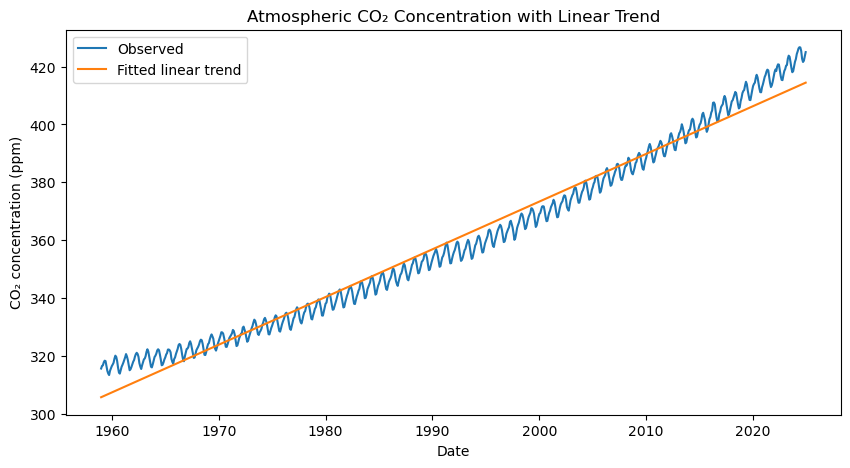

In [37]:
# here we Plot observed CO2 and linear trend
plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['co2_ppm'], label='Observed')
plt.plot(data['date'], predicted, label='Fitted linear trend')
plt.xlabel('Date')
plt.ylabel('CO₂ concentration (ppm)')
plt.title('Atmospheric CO₂ Concentration with Linear Trend')
plt.legend()
plt.show()

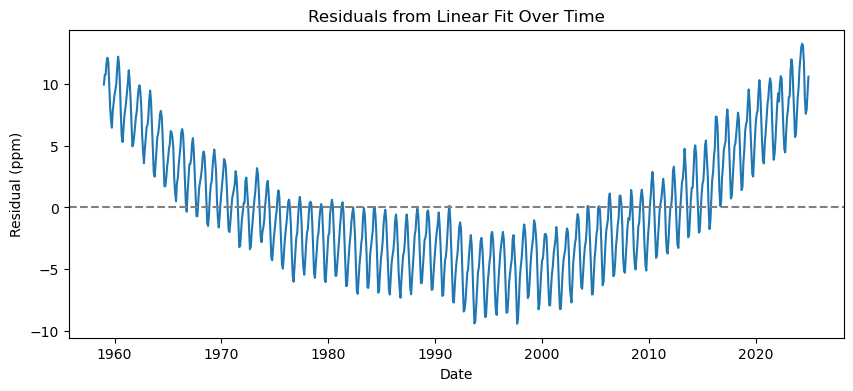

In [38]:
# Plot residuals over time
plt.figure(figsize=(10, 4))
plt.plot(data['date'], residuals)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Date')
plt.ylabel('Residual (ppm)')
plt.title('Residuals from Linear Fit Over Time')
plt.show()

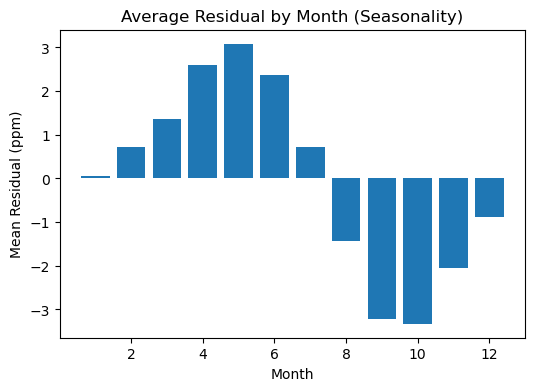

In [39]:
# Analyze seasonality by month on residuals
data['month'] = data['date'].dt.month
monthly_mean_residual = data.groupby('month')['residual'].mean()

plt.figure(figsize=(6, 4))
plt.bar(monthly_mean_residual.index, monthly_mean_residual.values)
plt.xlabel('Month')
plt.ylabel('Mean Residual (ppm)')
plt.title('Average Residual by Month (Seasonality)')
plt.show()

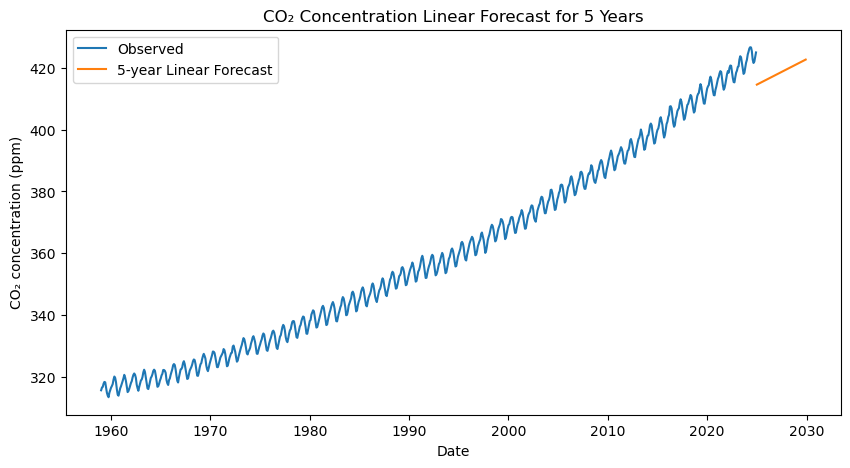

In [40]:
# Forecast CO2 for the next 5 years (60 months)
future_dates = pd.date_range(start=data['date'].max() + pd.offsets.MonthBegin(1), periods=60, freq='MS')
future_time_years = (future_dates - start_date).days / 365.25
future_co2_pred = intercept + slope * future_time_years

plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['co2_ppm'], label='Observed')
plt.plot(future_dates, future_co2_pred, label='5-year Linear Forecast')
plt.xlabel('Date')
plt.ylabel('CO₂ concentration (ppm)')
plt.title('CO₂ Concentration Linear Forecast for 5 Years')
plt.legend()
plt.show()